In [1]:
import pyarrow.feather as feather
import numpy as np
import pandas as pd
import json
import os
from oedisi.types.data_types import Topology

directory = "../outputs"


In [21]:
voltage_real = feather.read_feather(
    os.path.join(directory, "voltage_real.feather")
)
voltage_imag = feather.read_feather(
    os.path.join(directory, "voltage_imag.feather")
)

with open(os.path.join(directory, "topology.json")) as f:
    topology = Topology.parse_obj(json.load(f))
    base_voltage_df = pd.DataFrame(
        {
            "id": topology.base_voltage_magnitudes.ids,
            "value": topology.base_voltage_magnitudes.values,
        }
    )
    base_voltage_df.set_index("id", inplace=True)
    base_voltages = base_voltage_df["value"]

true_voltages = voltage_real.drop("time", axis=1) + 1j * voltage_imag.drop(
    "time", axis=1
)
true_voltages["time"] = voltage_real["time"]
true_voltages.set_index("time", inplace=True)

voltage_mag = feather.read_feather(os.path.join(directory, "voltage_mag.feather"))
estimated_time = voltage_mag["time"]
voltage_mag.drop("time", axis=1)
voltage_angle = feather.read_feather(
    os.path.join(directory, "voltage_angle.feather")
).drop("time", axis=1)

estimated_voltages = voltage_mag * np.exp(1j * voltage_angle)
estimated_voltages["time"] = estimated_time
estimated_voltages.set_index("time", inplace=True)

time_intersection = pd.merge(
    true_voltages, estimated_voltages, left_index=True, right_index=True
).index.to_numpy()

estimated_voltages = estimated_voltages.loc[time_intersection, :]
true_voltages = true_voltages.loc[time_intersection, :]

estimated_voltages = estimated_voltages.reindex(true_voltages.columns, axis=1)



In [14]:
def errors(true_voltages, estimated_voltages):
    true_mag = np.abs(true_voltages)
    nonzero_parts = true_mag != 0.0
    MAPE = np.mean(
        np.array(np.abs(true_mag - np.abs(estimated_voltages)) / true_mag)[
            nonzero_parts
        ]
        * 100
    )
    angle_difference = np.abs(np.angle(true_voltages) - np.angle(estimated_voltages))
    angle_difference[angle_difference >= np.pi] = (
        2 * np.pi - angle_difference[angle_difference >= np.pi]
    )
    MAE = np.mean(np.array(angle_difference)[nonzero_parts] * 180 / np.pi)
    return MAPE, MAE

def error_table(true_voltages, estimated_voltages):
    error_table = []
    for i, t in enumerate(true_voltages.index):
        MAPE, MAE = errors(true_voltages.iloc[i, :], estimated_voltages.iloc[i, :])
        error_table.append({"t": t, "MAPE": MAPE, "MAE": MAE})
    return pd.DataFrame(error_table)


err_table = error_table(true_voltages, estimated_voltages)
MAPE, MAE = errors(true_voltages, estimated_voltages)
print(f"MAPE = {MAPE}, MAE={MAE}")

MAPE = 0.011871283004921518, MAE=0.05851994895555378


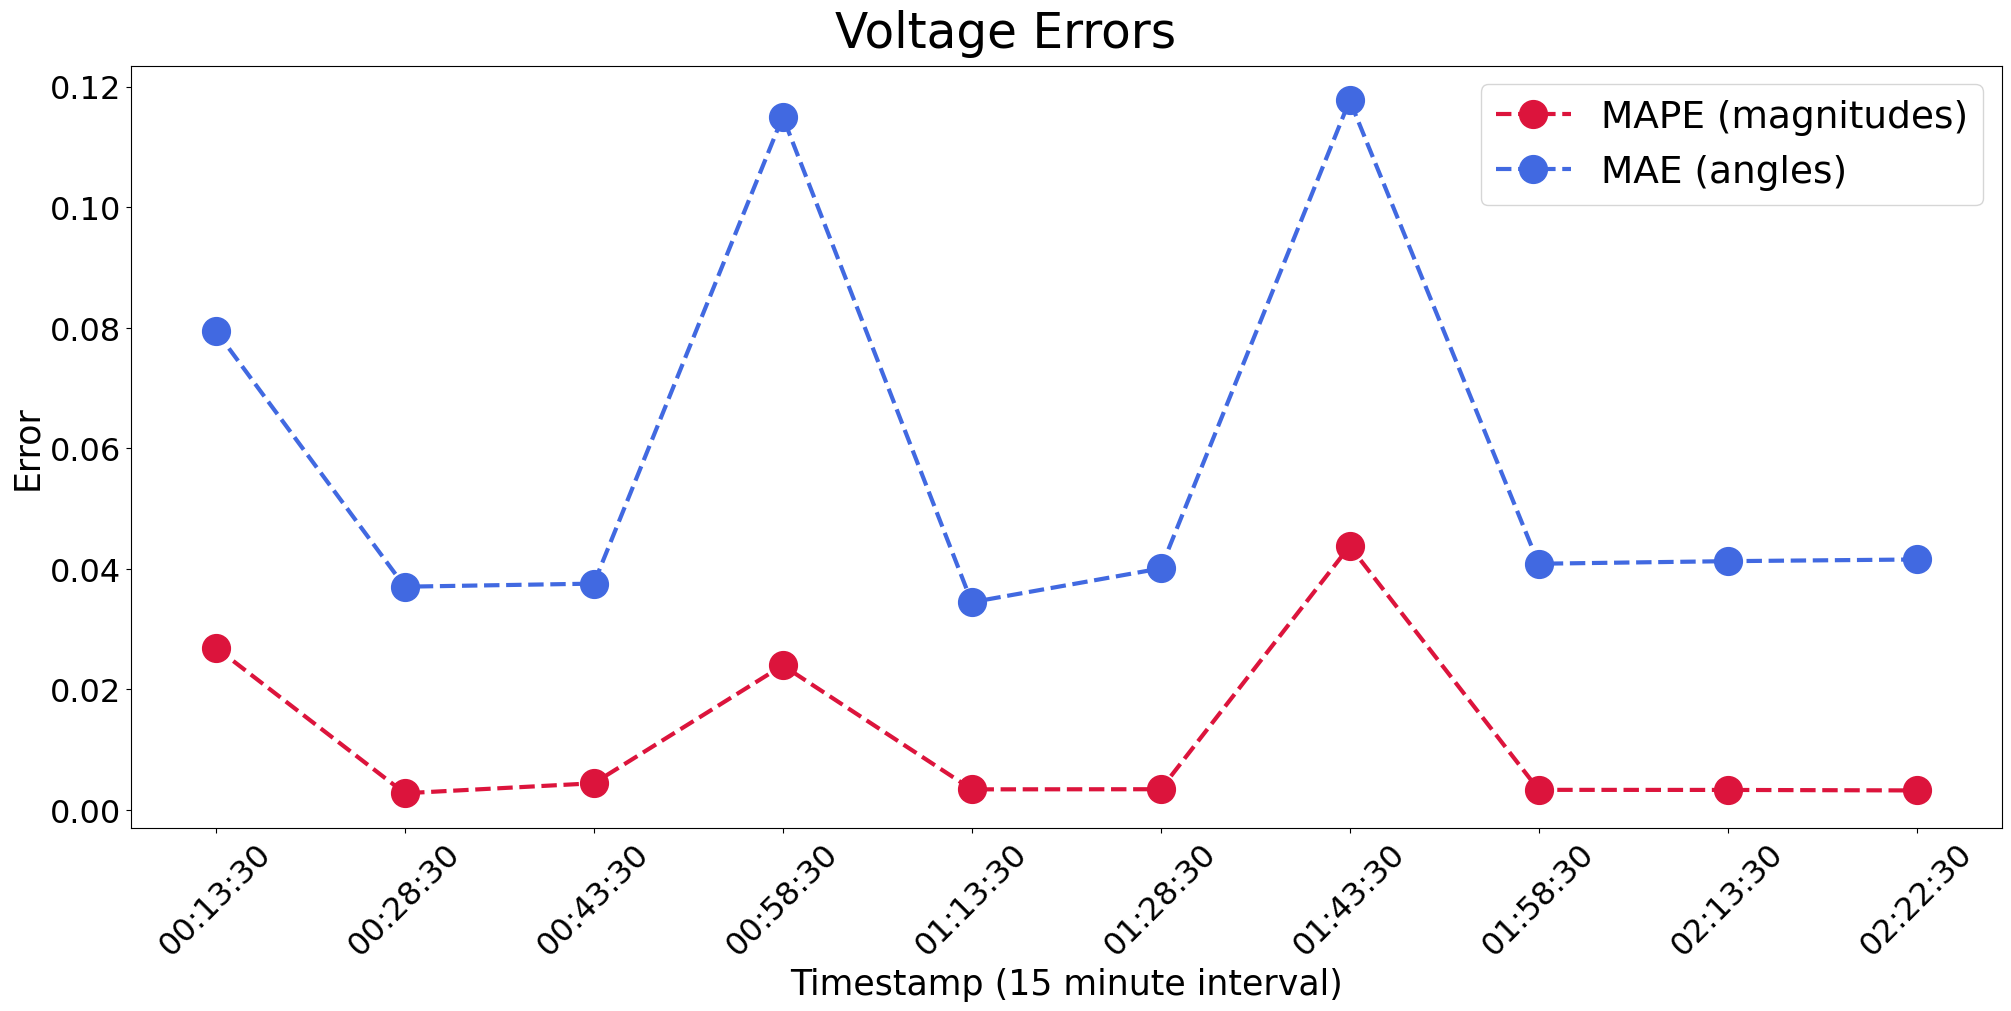

In [15]:
import matplotlib.pyplot as plt
from datetime import datetime



def plot_errors(
        err_table:pd.DataFrame, 
        **kwargs):
    """
    Plots the voltage errors: MAPE/MAE

    Inputs:
        err_table - pandas Dataframe of MAPE and MAE errors
        kwargs - keyword arguments
            figsize - size of figure, default is (20,10)
            fontsize - fontsize of the axis labels, default is 20
    
    Output:
        fig - figure object created
    """
    # default arguments
    figsize = kwargs.get('figsize',(20,10))
    label_fontsize = kwargs.get('fontsize', 25)
    legend_fontsize = label_fontsize + 2
    ticklabel_fontsize = label_fontsize - 2
    title_fontsize = label_fontsize + 10

    # Plots
    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
    ax.plot(
        err_table["t"], err_table["MAPE"], 
        label="MAPE (magnitudes)", 
        color="crimson", ls="dashed", marker="o",
        lw = 3.0, markersize=20)
    ax.plot(
        err_table["t"], err_table["MAE"], 
        label="MAE (angles)", 
        color="royalblue", ls="dashed", marker="o",
        lw = 3.0, markersize=20)
    
    # Formatting
    ax.legend(fontsize=legend_fontsize, markerscale=1)
    ax.set_ylabel("Error", fontsize=label_fontsize)
    ax.set_xlabel("Timestamp (15 minute interval)", fontsize=label_fontsize)

    xtixlabels = [datetime.strptime(err_table["t"][i], 
            "%Y-%m-%d %H:%M:%S").time().strftime("%H:%M:%S") for i in range(len(err_table))]
    ax.set_xticks(err_table["t"], xtixlabels, rotation=45)
    ax.tick_params(axis="x", labelsize=ticklabel_fontsize)
    ax.tick_params(axis="y", labelsize=ticklabel_fontsize)

    fig.suptitle("Voltage Errors", fontsize=title_fontsize)
    return fig




plot_errors(err_table).savefig(os.path.join(directory, "errors.png"))



278


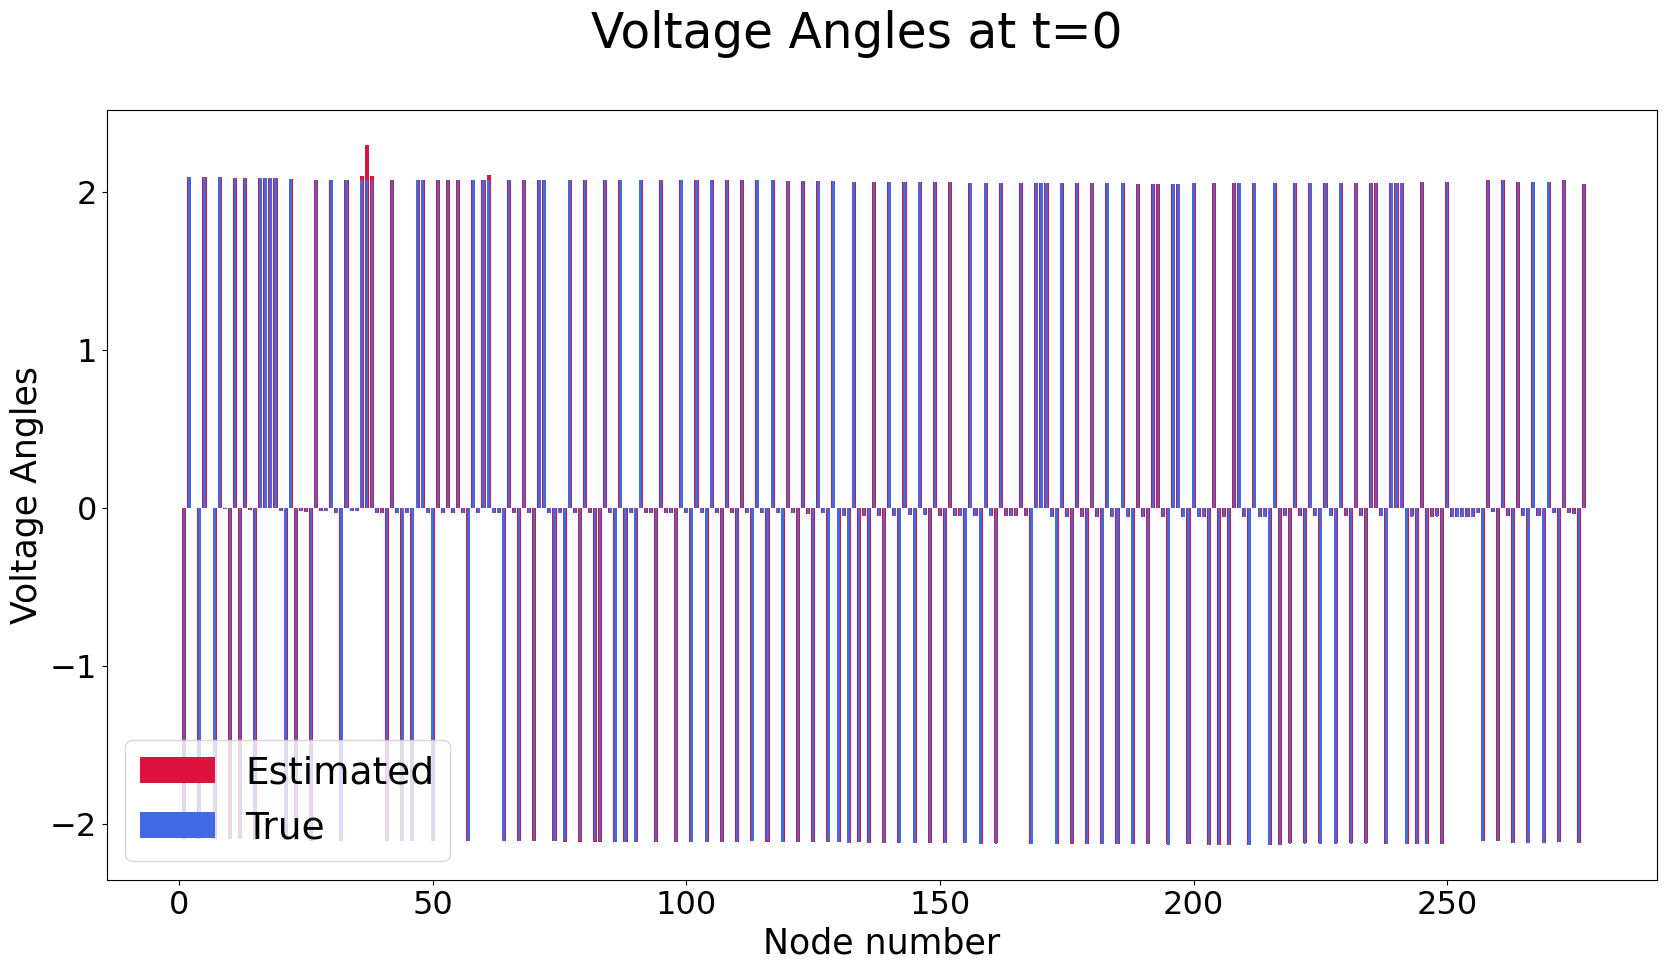

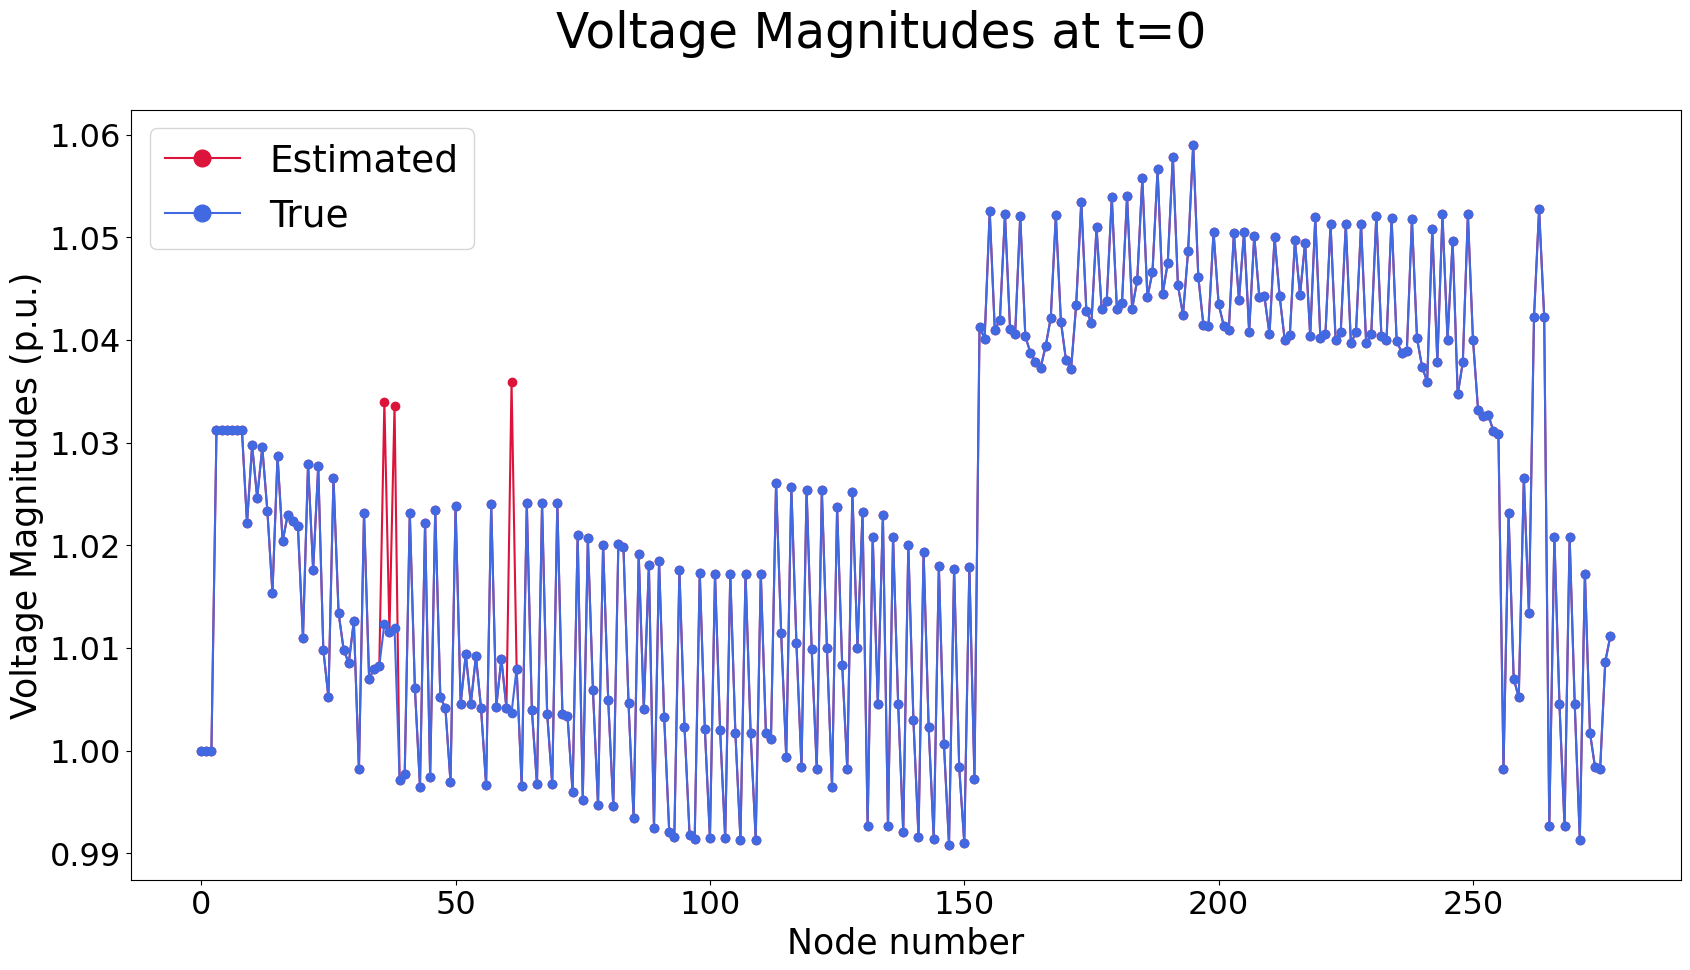

In [16]:
def plots(true_voltages, estimated_voltages, time=0, unit="kV", **kwargs):

    n_nodes = true_voltages.shape[0]
    x_axis = np.arange(n_nodes)
    print(n_nodes)
    
    label_fontsize = kwargs.get('fontsize', 25)
    legend_fontsize = label_fontsize + 2
    ticklabel_fontsize = label_fontsize - 2
    title_fontsize = label_fontsize + 10
    
    # Plot 1
    fig1, ax = plt.subplots(figsize=(20, 10))
    ax.bar(x_axis, np.angle(estimated_voltages), color="crimson")
    ax.bar(x_axis, np.angle(true_voltages), width=0.5, color="royalblue")
    # Formatting
    ax.set_xlabel("Node number", fontsize=label_fontsize)
    ax.set_ylabel("Voltage Angles", fontsize=label_fontsize)
    ax.legend(["Estimated", "True"], fontsize=legend_fontsize)
    ax.tick_params(axis="x", labelsize=ticklabel_fontsize)
    ax.tick_params(axis="y", labelsize=ticklabel_fontsize)
    fig1.suptitle(f"Voltage Angles at t={time}", fontsize=title_fontsize)

    # Plot 2
    fig2, ax = plt.subplots(figsize=(20, 10))
    ax.plot(x_axis, np.abs(estimated_voltages), "-o", color="crimson")
    ax.plot(x_axis, np.abs(true_voltages), "-o", color="royalblue")
    # Formatting
    ax.set_xlabel("Node number", fontsize=label_fontsize)
    ax.set_ylabel(f"Voltage Magnitudes ({unit})", fontsize=label_fontsize)
    ax.legend(["Estimated", "True"], fontsize=legend_fontsize, markerscale=2)
    ax.tick_params(axis="x", labelsize=ticklabel_fontsize)
    ax.tick_params(axis="y", labelsize=ticklabel_fontsize)
    fig2.suptitle(f"Voltage Magnitudes at t={time}", fontsize=title_fontsize)
    return fig1, fig2



fig1, fig2 = plots(
    true_voltages.iloc[0, :] / base_voltages,
    estimated_voltages.iloc[0, :] / base_voltages,
    unit="p.u.",
)

fig1.savefig(os.path.join(directory, "voltage_angles_0.png"))
fig2.savefig(os.path.join(directory, "voltage_magnitudes_0.png"))


if len(true_voltages) >= 94:
    fig1, fig2 = plots(
        true_voltages.iloc[93, :] / base_voltages,
        estimated_voltages.iloc[93, :] / base_voltages,
        time=93,
        unit="p.u.",
    )
    fig1.savefig(os.path.join(directory, "voltage_angles_95.png"))
    fig2.savefig(os.path.join(directory, "voltage_magnitudes_95.png"))

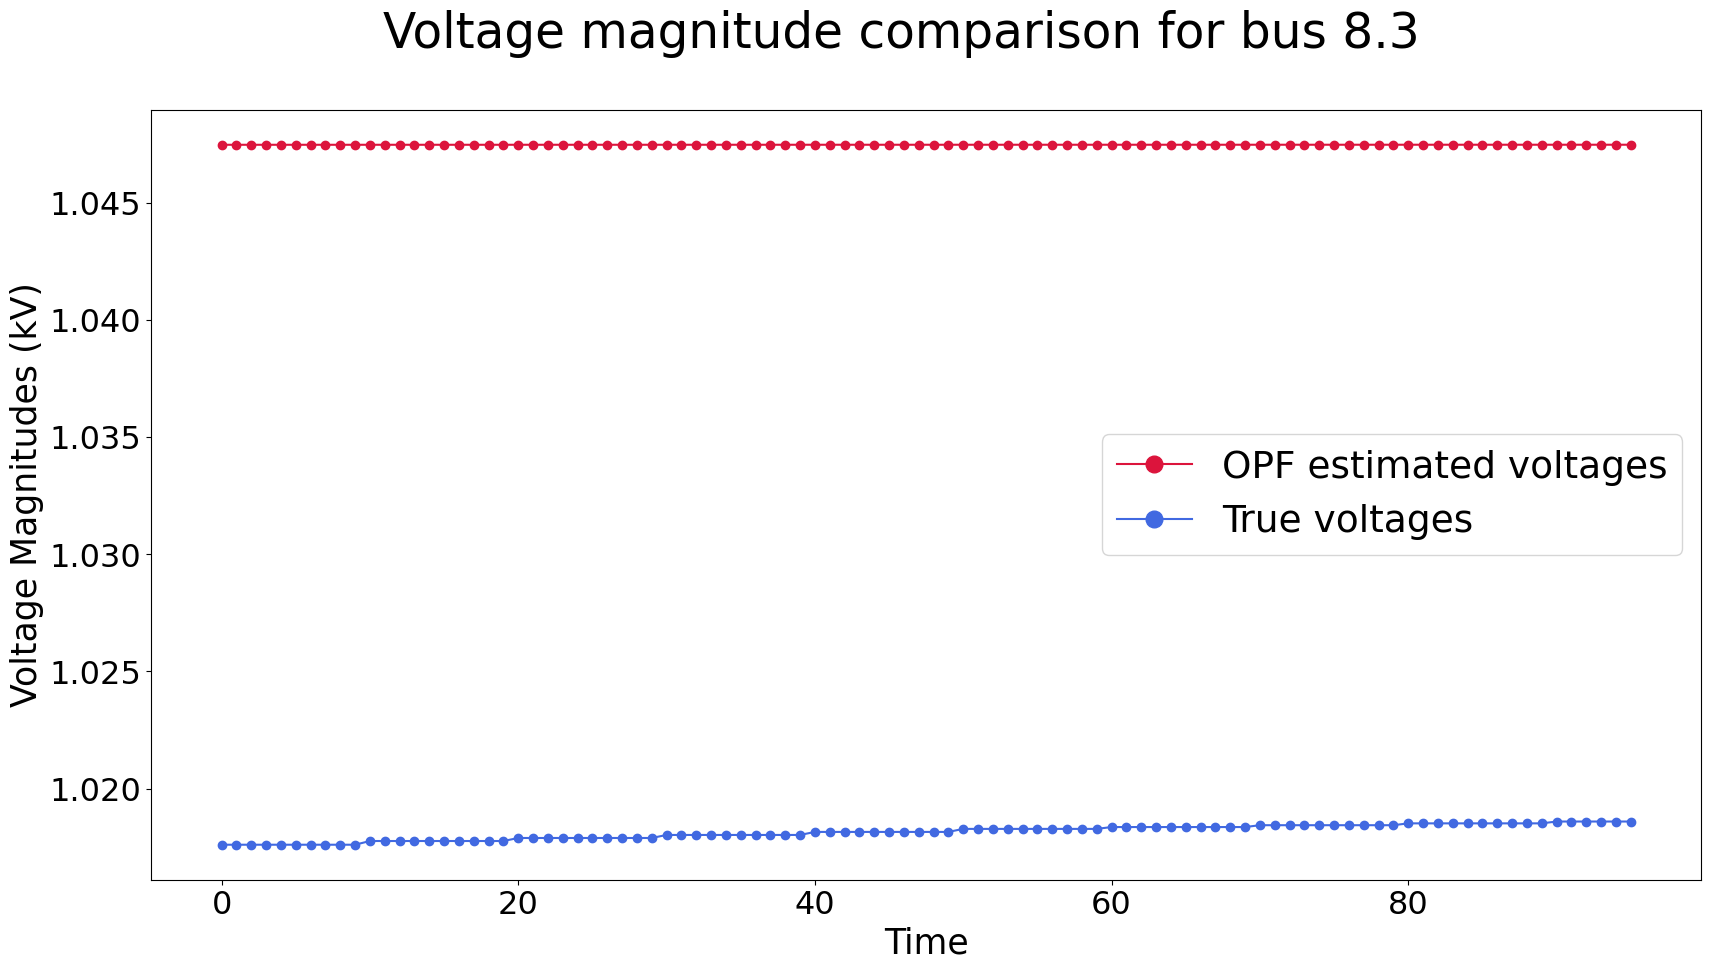

In [34]:
import matplotlib.pyplot as plt

def compare_voltages(
        df_opf_voltages, df_true_voltages, base_voltages,
        bus=None, time=0, unit="kV", 
        **kwargs
        ):
    
    # keyword arguments
    label_fontsize = kwargs.get('fontsize', 25)
    legend_fontsize = label_fontsize + 2
    ticklabel_fontsize = label_fontsize - 2
    title_fontsize = label_fontsize + 10

    # common bus or common time: if bus=None, then plot for common time
    if not bus:
        opf_voltages = df_opf_voltages.iloc[time,:]
        true_voltages = df_true_voltages.iloc[time,:] / base_voltages
        xlabel = "Node number"
        suptitle = f"Voltage magnitude comparison at t={time}"
    else:
        opf_voltages = df_opf_voltages[bus]
        true_voltages = df_true_voltages[bus] / base_voltages[bus]
        xlabel = "Time"
        suptitle = f"Voltage magnitude comparison for bus {bus}"
        

    # Plot the comparison
    fig, ax = plt.subplots(figsize=(20, 10))
    x_axis = np.arange(true_voltages.shape[0])
    ax.plot(x_axis, opf_voltages, "-o", color="crimson")
    ax.plot(x_axis, true_voltages, "-o", color="royalblue")
    # Formatting
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(f"Voltage Magnitudes ({unit})", fontsize=label_fontsize)
    ax.legend(["OPF estimated voltages", "True voltages"], 
              fontsize=legend_fontsize, markerscale=2)
    ax.tick_params(axis="x", labelsize=ticklabel_fontsize)
    ax.tick_params(axis="y", labelsize=ticklabel_fontsize)
    fig.suptitle(suptitle, fontsize=title_fontsize)
    return fig

opf_voltages = feather.read_feather(
    os.path.join(directory, 
                 "opf_voltage_mag.feather")
                 ).drop("time", axis=1)
true_voltages = np.abs(voltage_real.drop("time", axis=1) + 1j * voltage_imag.drop("time", axis=1))

fig = compare_voltages(
    opf_voltages, true_voltages, base_voltages, 
    bus="8.3"
    )